In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from linear_models import ftr_transform, max_ftr_transform

# load results

In [2]:
wave = "coif2"
dirs = [wave + "_saliency_warmstart_seed=1"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/biology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave=wave, mode='zero', J=4, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [3]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)

index2o = {}
index2t = {}
num = 0
for i, _ in enumerate(lamL1wave_grid):
    for j, _ in enumerate(lamL1attr_grid):
        loc = (lamL1wave == lamL1wave_grid[i]) & (lamL1attr == lamL1attr_grid[j])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            index2o[(i,j)] = loc
            index2t[num] = (i,j)
        num += 1
            
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)
psi_list = []
wt_list = []
for r in range(R):
    for c in range(C):
        wt = mos[index2o[(r,c)]]
        wt_list.append(wt)
        phi, psi, x = get_wavefun(wt)
        psi_list.append(psi)            

# Plotting

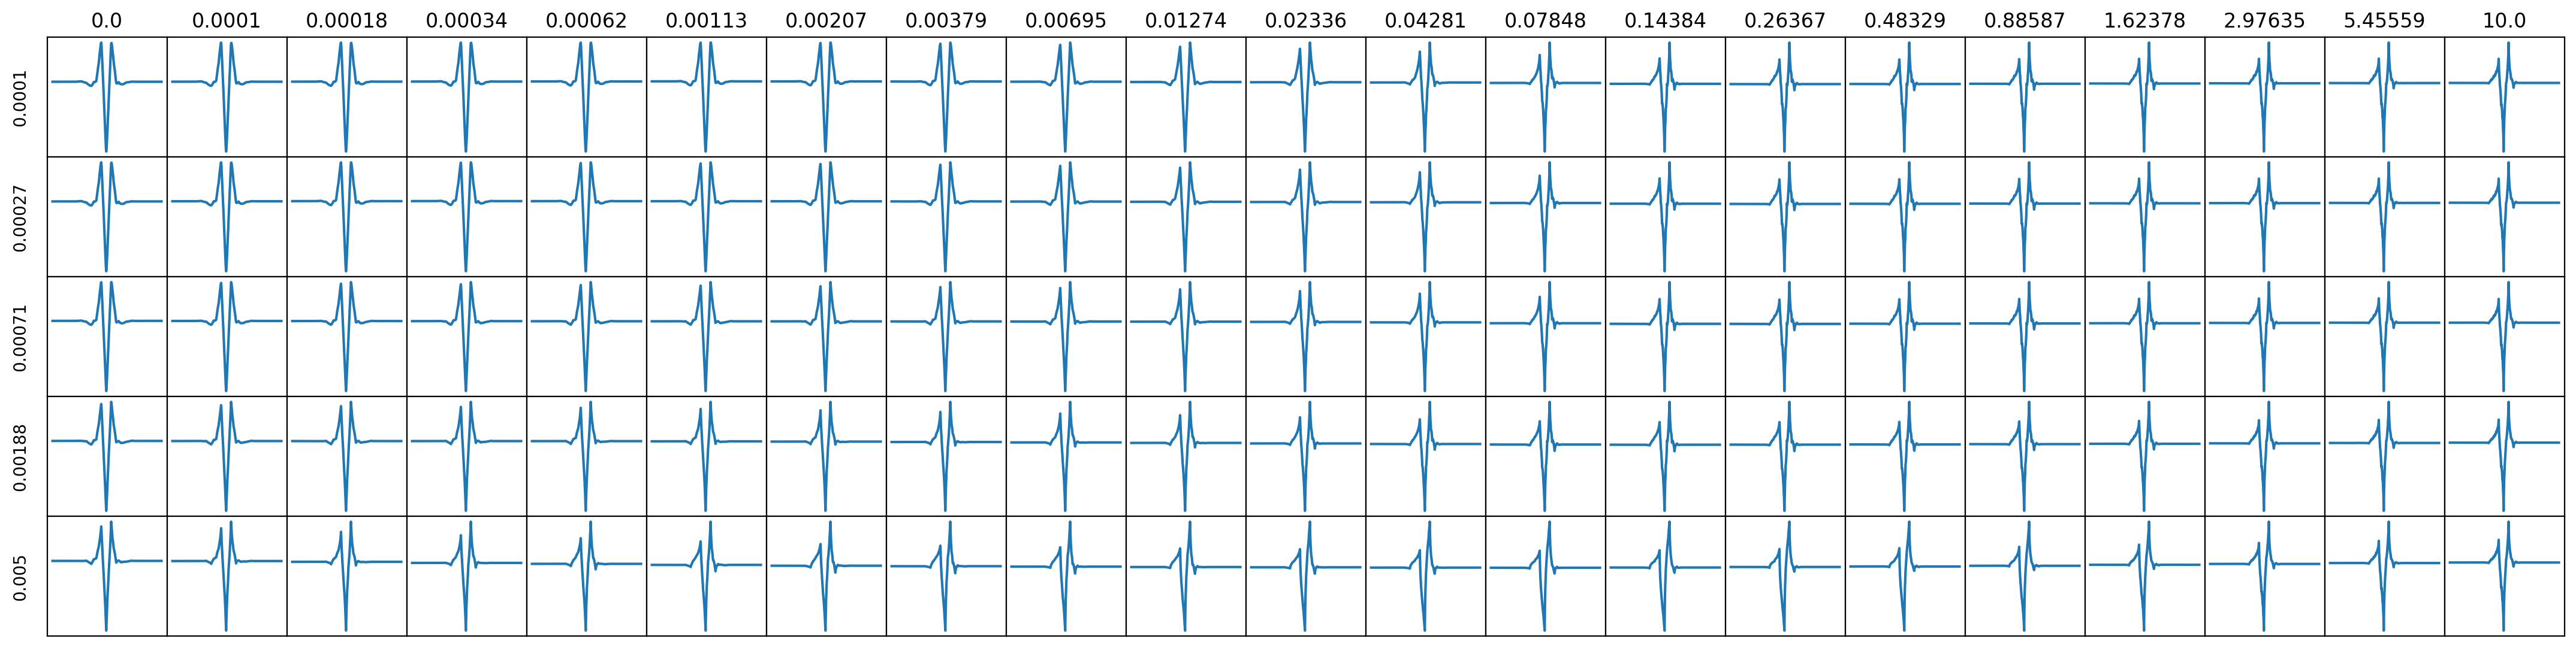

In [4]:
plt.figure(figsize=(C+1, R+1), dpi=200)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

i = 0
for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, psi_list[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamL1wave_grid[r]))
        if r == 0:
            plt.title(str(lamL1attr_grid[c]))
        i += 1
plt.show() 


# calculate accuracy

In [59]:
reg = {}
log = {}
reg_o, log_o = [], []
K = 20
wt_o = DWT1d(wave=wave, mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)

for use_reg, param in zip([True, False], [10, 100]):
    (train_loader, test_loader) = get_dataloader(p.data_path, 
                                                 batch_size=p.batch_size,
                                                 is_continuous=use_reg)   
    
    for i,wt in enumerate(wt_list):
        wt = wt.to('cpu')
        (X, y), (X_test, y_test) = ftr_transform(wt, train_loader, test_loader)
        
        if use_reg:
            reg[i] = []
            clf = Ridge(alpha=param).fit(X, y)
            coef = clf.coef_.reshape(-1)
            for k in range(1,K):
                index = np.argsort(abs(coef))[::-1][:k]
                clf = Ridge(alpha=param).fit(X[:,index], y)
                preds = clf.predict(X_test[:,index])
                acc = metrics.r2_score(y_test, preds)
                reg[i].append(acc) 
            reg[i] = np.array(reg[i])
        else:
            log[i] = []
            clf = LogisticRegression(C=param).fit(X, y)
            coef = clf.coef_.reshape(-1)
            for k in range(1,K):
                index = np.argsort(abs(coef))[::-1][:k]
                clf = LogisticRegression(C=param).fit(X[:,index], y)
                preds = clf.predict(X_test[:,index])
                preds = 1 * (preds > 0)
                acc = metrics.accuracy_score(y_test, preds)
                log[i].append(acc)
            log[i] = np.array(log[i])
        print('\r {}'.format(i), end='')
    
    # ordinary wavelet
    wt_o = wt_o.to('cpu')
    (X, y), (X_test, y_test) = ftr_transform(wt_o, train_loader, test_loader)
    if use_reg:
        # regression
        clf = Ridge(alpha=param).fit(X, y)
        coef = clf.coef_.reshape(-1)
        for k in range(1,K):
            index = np.argsort(abs(coef))[::-1][:k]
            clf = Ridge(alpha=param).fit(X[:,index], y)
            preds = clf.predict(X_test[:,index])
            acc = metrics.r2_score(y_test, preds)
            reg_o.append(acc) 
        reg_o = np.array(reg_o)
    else:
        # classification
        clf = LogisticRegression(C=param).fit(X, y)
        coef = clf.coef_.reshape(-1)
        for k in range(1,K):
            index = np.argsort(abs(coef))[::-1][:k]
            clf = LogisticRegression(C=param).fit(X[:,index], y)
            preds = clf.predict(X_test[:,index])
            preds = 1 * (preds > 0)
            acc = metrics.accuracy_score(y_test, preds)
            log_o.append(acc)
        log_o = np.array(log_o)    

reg = np.array(list(reg.values()))
log = np.array(list(log.values()))

 104

In [60]:
regs = []
logs = []
for i,_ in enumerate(wt_list):
    print('wavelet index:', i, np.max((reg[i] - reg_o)[:5]), np.max((log[i] - log_o)[:5]))
    regs.append(np.max((reg[i] - reg_o)[:5]))
    logs.append(np.max((log[i] - log_o)[:5]))
regs = np.array(regs)
logs = np.array(logs)

wavelet index: 0 0.00021261814448370053 0.0009950248756218638
wavelet index: 1 0.0050773900992672205 0.0019900497512438386
wavelet index: 2 0.0051252228858637006 0.0019900497512438386
wavelet index: 3 0.005037132380455223 0.0019900497512438386
wavelet index: 4 0.004917840489455649 0.0009950248756218638
wavelet index: 5 0.004770059730461962 0.0
wavelet index: 6 0.004542524179194096 0.0009950248756219748
wavelet index: 7 0.004015156694920585 0.0019900497512437276
wavelet index: 8 0.002945448936518047 -0.0009950248756218638
wavelet index: 9 -0.0036243047633016667 -0.0009950248756218638
wavelet index: 10 -0.005763323742571491 -0.0019900497512437276
wavelet index: 11 -0.009221363161573737 -0.00995024875621886
wavelet index: 12 -0.012878093533755575 -0.011940298507462699
wavelet index: 13 -0.015382627292093831 -0.017910447761193993
wavelet index: 14 -0.0160908140573357 -0.017910447761193993
wavelet index: 15 -0.015657258412497432 -0.017910447761193993
wavelet index: 16 -0.014656772938776874 

In [61]:
diff = []
for i,_ in enumerate(wt_list):
    diff.append((log[i] - log_o))
diff = np.array(diff)

(array([12.,  5., 12.,  9., 18., 23.,  4., 16.,  2.,  4.]),
 array([-0.01791045, -0.01552239, -0.01313433, -0.01074627, -0.00835821,
        -0.00597015, -0.00358209, -0.00119403,  0.00119403,  0.00358209,
         0.00597015]),
 <a list of 10 Patch objects>)

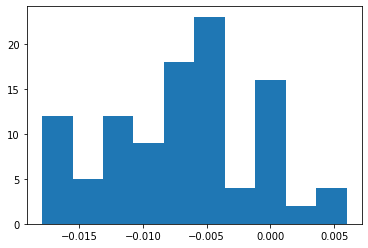

In [67]:
plt.hist(diff[:,0].flatten())

# calculate accuracy

wavelet with best regression performance

Hyperparameter: lamL1wave=0.005000 lamL1attr=0.263670
Error: Recon=0.000065
Sparsity: Wave=4.095278
Interp: Saliency=0.369015 InputXGrade=0.283722
Wavelet loss: lSum=0.000000 hsum=0.000038 L2norm=0.000000 CMF=0.000006 Conv=0.000000


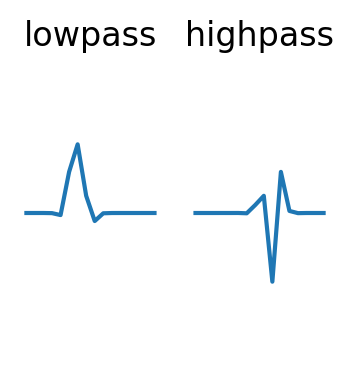

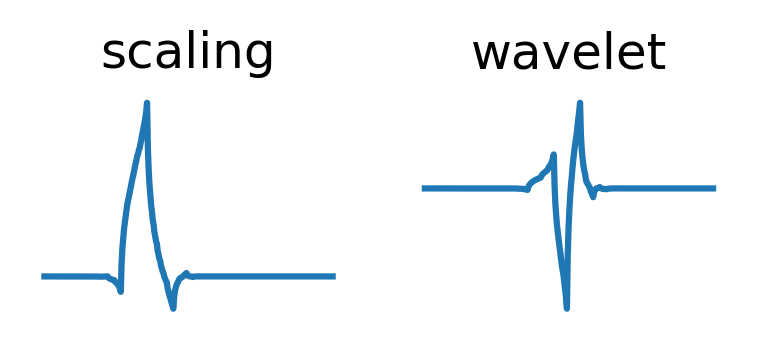

In [21]:
a = reg[:,:4]
idx, _ = np.unravel_index(a.argmax(), a.shape)
idx1, idx2 = index2t[idx]
wt = mos[index2o[(idx1, idx2)]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index2o[(idx1, idx2)]], res['lamL1attr'][index2o[(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index2o[(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][index2o[(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][index2o[(idx1, idx2)]], res['L1inputxgrad_loss'][index2o[(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['hsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['L2norm_loss'][index2o[(idx1, idx2)]],
                                                                                          res['CMF_loss'][index2o[(idx1, idx2)]],
                                                                                          res['conv_loss'][index2o[(idx1, idx2)]]))


plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

wavelet with best classification performance

Hyperparameter: lamL1wave=0.005000 lamL1attr=0.143840
Error: Recon=0.000011
Sparsity: Wave=4.083647
Interp: Saliency=0.369632 InputXGrade=0.283640
Wavelet loss: lSum=0.000000 hsum=0.000006 L2norm=0.000000 CMF=0.000001 Conv=0.000000


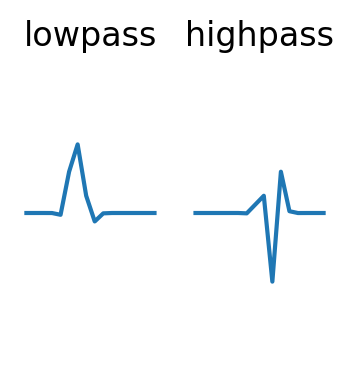

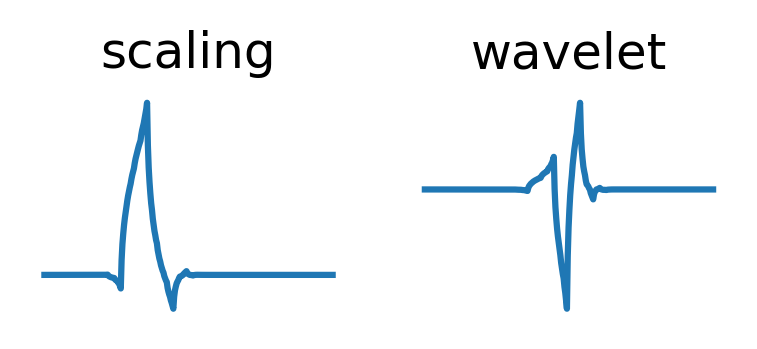

In [22]:
a = log[:,:4]
idx, _ = np.unravel_index(a.argmax(), a.shape)
idx1, idx2 = index2t[idx]
wt = mos[index2o[(idx1, idx2)]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index2o[(idx1, idx2)]], res['lamL1attr'][index2o[(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index2o[(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][index2o[(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][index2o[(idx1, idx2)]], res['L1inputxgrad_loss'][index2o[(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['hsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['L2norm_loss'][index2o[(idx1, idx2)]],
                                                                                          res['CMF_loss'][index2o[(idx1, idx2)]],
                                                                                          res['conv_loss'][index2o[(idx1, idx2)]]))


plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

In [11]:
# data = iter(test_loader).next()[0]
# sp_level = 40
# data_t = thresh_attrs(wt(data), sp_level)
# data_to = thresh_attrs(wt_o(data), sp_level)
# recon = wt.inverse(data_t)
# recon_o = wt_o.inverse(data_to)

# print(torch.norm(data - recon)/100)
# print(torch.norm(data - recon_o)/100)

# for i in range(len(data_t)):
#     print(data_t[i].shape)